# Calcul et analyse de la contrainte homogénéisée (moyenne volumique)

Ce notebook lit `datas/S11_Ss.rpt`, extrait `IVOL` et `S.S11` aux points d'intégration, calcule la moyenne volumique :

$$\bar{\sigma} = \frac{\sum_i V_i \sigma_i}{\sum_i V_i}$$

Le parsing est robuste aux en-têtes et aux lignes non numériques.

In [1]:
# Lecture et parsing robuste du fichier S11_Ss.rpt
import re
import numpy as np
from pathlib import Path

# Chemin relatif (notebook à la racine du workspace)
fp = Path('datas') / 'S11_Ss.rpt'
text = fp.read_text(encoding='utf-8', errors='ignore')

# Cherche toutes les lignes contenant: ElementLabel  IntPt  IVOL  S.S11
pattern = re.compile(r'^\s*(\d+)\s+(\d+)\s+([0-9eE+\-.]+)\s+([0-9eE+\-.]+)', re.M)
matches = pattern.findall(text)

ivols = []
s11s = []
for m in matches:
    # m = (element_label, int_pt, ivol_str, s11_str)
    try:
        ivol = float(m[2])
        s11 = float(m[3])
    except ValueError:
        continue
    ivols.append(ivol)
    s11s.append(s11)

ivols = np.array(ivols, dtype=float)
s11s = np.array(s11s, dtype=float)

# Vérifications rapides
n = ivols.size
if n == 0:
    raise RuntimeError(f'Pas de données extraites depuis {fp}. Vérifier le format du fichier.')

# Calcul homogénéisé (moyenne volumique)
total_volume = ivols.sum()
weighted_sum = (ivols * s11s).sum()
homogenized = weighted_sum / total_volume

# Résultats complémentaires
unweighted_mean = s11s.mean()
std = s11s.std(ddof=1)
min_s11 = s11s.min()
max_s11 = s11s.max()

print(f'Points d\'intégration extraits : {n}')
print(f'Somme des volumes (IVOL) : {total_volume:.6e}')
print(f'Contrainte homogénéisée (moyenne volumique) : {homogenized:.6f}')
print(f'Moyenne non pondérée : {unweighted_mean:.6f}  |  Std (échantillon) : {std:.6f}')
print(f'S11 min/max : {min_s11:.6f} / {max_s11:.6f}')

# Liste des 10 contributions les plus importantes (volume * s11)
contri = ivols * s11s
idx_top = np.argsort(contri)[-10:][::-1]
top_list = [(int(i+1), ivols[i], s11s[i], contri[i]) for i in idx_top]
print('\nTop 10 contributions (ElementIndex, IVOL, S11, IVOL*S11):')
for t in top_list:
    print(t)

# Sauvegarde optionnelle des données extraites
out_csv = Path('s11_extracted.csv')
import csv
with out_csv.open('w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['IVOL','S11'])
    w.writerows(zip(ivols.tolist(), s11s.tolist()))
print(f'Extrait sauvegardé dans: {out_csv}')

Points d'intégration extraits : 7626
Somme des volumes (IVOL) : 2.056794e+02
Contrainte homogénéisée (moyenne volumique) : 4.387406
Moyenne non pondérée : 0.690186  |  Std (échantillon) : 1.667707
S11 min/max : 0.000000 / 8.078670

Top 10 contributions (ElementIndex, IVOL, S11, IVOL*S11):
(19, 0.363098, 5.41842, 1.96741746516)
(1063, 0.363098, 5.41842, 1.96741746516)
(964, 0.386093, 4.74037, 1.8302236744100002)
(152, 0.386093, 4.74037, 1.8302236744100002)
(24, 0.332155, 5.45583, 1.8121812136499997)
(1068, 0.332155, 5.45583, 1.8121812136499997)
(251, 0.363098, 4.94695, 1.7962276511)
(831, 0.363098, 4.94695, 1.7962276511)
(599, 0.363098, 4.94296, 1.79477889008)
(483, 0.363098, 4.94296, 1.79477889008)
Extrait sauvegardé dans: s11_extracted.csv


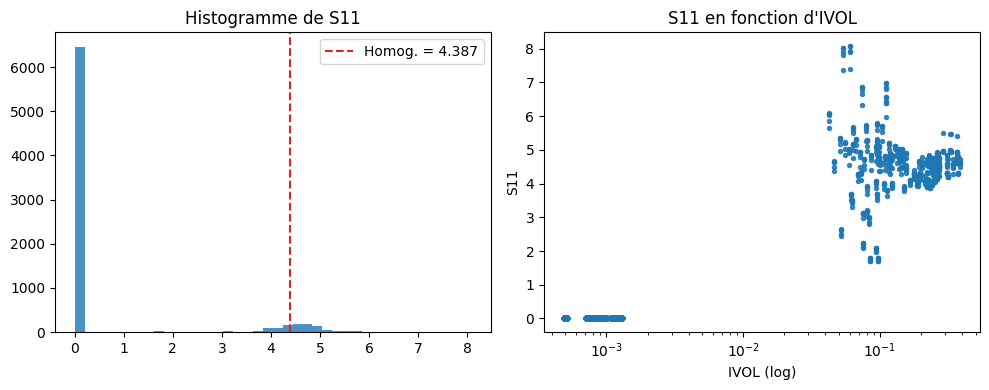

In [2]:
# Visualisations : histogramme et scatter des volumes vs contrainte
import matplotlib.pyplot as plt
import numpy as np

# suppose ivols, s11s, homogenized déjà définis (exécuter cellule précédente)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(s11s, bins=40, color='C0', alpha=0.8)
plt.axvline(homogenized, color='C3', linestyle='--', label=f'Homog. = {homogenized:.3f}')
plt.title('Histogramme de S11')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(ivols, s11s, s=8, alpha=0.6)
plt.xscale('log')
plt.xlabel('IVOL (log)')
plt.ylabel('S11')
plt.title('S11 en fonction d\'IVOL')
plt.tight_layout()
plt.show()